In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import numpy.ma as ma
from matplotlib.patches import Polygon
import cmasher as cmr
%matplotlib inline


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

from thop import profile
from torch.autograd.functional import jacobian

In [2]:
def EI_calculate_pdet(A, Sigma):
    """
    Calculate the Effective Information (EI) based on the pseudo-determinant.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    float: The logarithm of the pseudo-determinant (EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and return the product of singular values greater than 1e-10
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    pseudo_det = np.prod(s[s > 1e-10])  # Only consider non-zero singular values
    
    # Effective Information (EI) is the log of the pseudo-determinant scaled by constants
    EI = math.log(abs(pseudo_det)**(1/2) / (2 * np.pi * np.e)**(n / 2))
    
    return EI


def EI_calculate_m_star(A, Sigma, k):
    """
    Calculate the maximum Effective Information (max EI) using the first k singular values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    k (int): The number of singular values to consider.
    
    Returns:
    float: The logarithm of the pseudo-determinant using the top k singular values (max EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and take the product of the first k singular values
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    max_pseudo_det = np.prod(s[:k])
    
    # max EI is the log of the top k singular values' product, scaled by constants
    max_EI = math.log(abs(max_pseudo_det)**(1/2) / (2 * np.pi * np.e)**(k / 2))
    
    return max_EI

def Gamma(alpha, r_eps, A, Sigma):
    """
    Calculate the Gamma function based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, of size n x n.
    Sigma (ndarray): Input matrix Sigma, of size n x n.
    
    Returns:
    float: The computed Gamma value.
    """
    n = A.shape[1]
    
    # Compute the SVD of A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Compute the SVD of Sigma
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    gamma_value = (2 * np.pi / alpha)**(n / 2) * \
                  np.prod(s_AS2[:r_eps])**(1 / 2 - alpha / 4) * \
                  np.prod(s_S2[:r_eps])**(alpha / 4)
    
    return gamma_value

def gamma_0(alpha, r, A, Sigma):
    """
    Calculate gamma_0 based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma_0 value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma_0 using the top r singular values
    gamma_0_value = np.sum(np.log(s_AS2[:r]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:n]))*(alpha / 4)
    
    return gamma_0_value


def gamma(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return gamma_value

def gamma_geq0(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return max(gamma_value,0)


def calculate_threshold(A, Sigma):
    """
    Calculate the threshold based on the singular values of A^T * Sigma^-1 * A.
    
    Parameters:
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: The threshold value and its corresponding index.
    """
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # Compute the differences between consecutive singular values
    diff = np.diff(s_AS2)
    
    # Compute the ratio of consecutive singular values to avoid division by zero
    ratio = s_AS2[:-1] / s_AS2[1:]  # Element-wise division
    
    # Find the index of the maximum product of difference and ratio
    max_diff_index = np.argmax(np.abs(diff) * np.abs(ratio))
    
    # Return the threshold value and the index (index is adjusted by +1)
    return s_AS2[max_diff_index + 1], max_diff_index + 1

def clear_causal_emergence(A, Sigma):
    """
    Calculate the causal emergence based on changes in effective information (EI) and gamma values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J_R and Delta_Gamma_0 values representing causal emergence.
    """
    n = A.shape[1]
    
    # Calculate the rank of A^T * Sigma^-1 * A
    rk = np.linalg.matrix_rank(A.T @ np.linalg.inv(Sigma) @ A)

    # Calculate the change in effective information (Delta_J_R)
    Delta_J_R = (EI_calculate_m_star(A, Sigma, rk) / rk) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_0)
    Delta_Gamma_0 = (gamma(1, rk, A, Sigma) / rk) - (gamma_0(1, rk, A, Sigma) / n)
    
    return Delta_J_R, Delta_Gamma_0

def vague_causal_emergence(A, Sigma):
    """
    Calculate the vague causal emergence based on the threshold calculation for causal emergence.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing vague causal emergence.
    """
    n = A.shape[1]

    epsilon, rk_eps = calculate_threshold(A, Sigma)  # Get threshold epsilon and rk_eps
    
    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps


def vague_causal_emergence_customize(A, Sigma, rk_eps):
    """
    Calculate the customized vague causal emergence based on a given rk_eps.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    rk_eps (int): The rank parameter for customized calculation.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing customized vague causal emergence.
    """
    n = A.shape[0]

    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps

In [3]:
class Simple_Spring_Model():
    
    def __init__(self, device, R=3):
        self.device = device
        self.R = R
    
    
    def multi_steps_sir(self, s, steps, sigma,lam=1,miu=0.5,rou=-0.5,dt=0.01,interval=1): 
        #One sample point runs multiple time steps.
        batch_size = s.size()[0]
        s_hist = s
        sn_hist = self.perturb(s, 0, rou)
        for t in range(1,steps+1):
            s_next,i_next = self.SIR_step(s[:,0],s[:,1],lam,miu,dt=dt)
            #s_next = torch.Tensor(s_next).unsqueeze(0)
            s_next = torch.cat((s_next.unsqueeze(1),i_next.unsqueeze(1)),1)#s_next.to(self.device)
            if t%interval==0:
                s_hist = torch.cat((s_hist, s_next), 0)
                rand_next = self.perturb(s_next, sigma,rou)
                sn_hist = torch.cat((sn_hist, rand_next), 0)
            s = s_next
        return s_hist[batch_size:,:], sn_hist[batch_size:,:]
    
    def perturb(self, s, sigma,rou):
        prior = distributions.MultivariateNormal(torch.zeros(2,device=self.device), torch.tensor([[1,rou],[rou,1]],device=self.device))
        rand1=prior.sample([s.size()[0]])*sigma
        rand2=prior.sample([s.size()[0]])*sigma
        s1 = s[:,0].unsqueeze(1) + rand1
        s2 = s[:,1].unsqueeze(1) + rand2
        s1_= torch.cat((s1[:,[0]], s2[:,[0]]), 1)
        s2_= torch.cat((s1[:,[1]], s2[:,[1]]), 1)
        sr = torch.cat((s1_, s2_), 1)
        return sr
    
    
    def SIR_step(self,s,i,lam,miu,noise2=0,dt=0.01):
        
        if noise2==0:
            s=s-dt* lam * s * i
            i=i+dt*(lam * s * i - miu * i)
        else:
            prior = distributions.MultivariateNormal(torch.zeros(2,device=self.device).float(), torch.tensor([[1,0],[0,1]],device=self.device).float()*noise2*noise2)
            rand=prior.sample([1])
 
            s=s-dt* lam * s * i+rand[0,0]
            i=i+dt*(lam * s * i - miu * i)+rand[0,1]
        return s,i
    
    def SIS_step(self,s,i,lam,miu,dt=0.01):
        s=s-dt* lam * s * i + dt * miu * i
        i=i+dt* lam * s * i - dt * miu * i
        return s,i

  
    def generate_multistep_sir(self,size_list,steps,lam=1,miu=0.5,sigma=0.03,rou=-0.5,dt=0.01,noise2=0,interval=1):
        #Be able to build a sample set with missing values.
        s=torch.tensor([0],device=self.device)
        i=torch.tensor([0],device=self.device)
        while s.size()[0]<size_list[0]:
            s_=torch.rand([1],device=self.device)
            i_=torch.rand([1],device=self.device) 
            if (s_+i_)<=1:
                s = torch.cat((s,s_),0)
                i = torch.cat((i,i_),0)
        frac=1/(len(size_list)-1)
        for j,size in enumerate(size_list[1:]):
            s1=torch.tensor([frac * j],device=self.device)
            i1=torch.tensor([0],device=self.device)
            while s1.size()[0]<size:
                s_=(torch.rand([1],device=self.device) * frac) + frac * j
                i_=torch.rand([1],device=self.device) 
                if (s_+i_)<=1:
                    s1 = torch.cat((s1,s_),0)
                    i1 = torch.cat((i1,i_),0)
            s = torch.cat((s,s1[1:]),0)
            i = torch.cat((i,i1[1:]),0)
        
        s=s[1:].unsqueeze(1)
        i=i[1:].unsqueeze(1)
        size=s.size()[0]
        idx=torch.randperm(s.nelement())
        s=s.view(-1)[idx].view(s.size())
        i=i.view(-1)[idx].view(i.size())
        history = torch.cat((s,i),1)
        observ_hist = self.perturb(history,sigma,rou)
        for k in range(1,steps+1):
            s,i=self.SIR_step(s,i,lam,miu,noise2=noise2,dt=dt)
            sir = torch.cat((s,i),1)
            sir_p = self.perturb(sir, sigma,rou)
            if k%interval==0:
                history = torch.cat((history, sir),0)
                observ_hist = torch.cat((observ_hist, sir_p),0)
        return observ_hist[:-size,:],observ_hist[size:,:], history[:-size,:],history[size:,:]

def calculate_multistep_predict(model,s,i,steps = 10,stochastic=False,sigma=0.03,rou=-0.5,dt=0.01):
    #Out-of-distribution generalization testing function
    spring = Simple_Spring_Model(device=device)

    if stochastic:
        z = torch.randn([1, 2], device=device)*L/2 
    else:
        z=torch.tensor([[s,i]],device=device) 
    s = spring.perturb(z, sigma,rou)

    s_hist, z_hist = model.multi_step_prediction(s, steps)
    if use_cuda:
        s_hist = s_hist.cpu()
        z_hist = z_hist.cpu()

    rs_hist, rsn_hist = spring.multi_steps_sir(z, steps, sigma,rou=rou,dt=dt) 
    if use_cuda:
        rs_hist = rs_hist.cpu()
        rsn_hist = rsn_hist.cpu()

    means=torch.mean(torch.abs(rsn_hist-s_hist[1:,:]))
    #cums=torch.cumsum(means, 0)[-1] / steps
    return means.item()

In [4]:
class Neural(nn.Module):
    def __init__(self, sym_size, hidden_size, device,is_random=False):
        super(Neural, self).__init__()
        if sym_size % 2 !=0:
            sym_size = sym_size + 1
        self.device = device
        self.sym_size = sym_size
        self.hidden_size = hidden_size
        self.dynamics = nn.Sequential(nn.Linear(sym_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, sym_size))
 
    def forward(self, s):
        sh = s + self.dynamics(s)
        return sh
    
    def multi_step_prediction(self, x, steps):
        batch_size = x.size()[0]
        x_hist = x
        for t in range(steps):    
            x_next = self.forward(x)
            x_hist = torch.cat((x_hist, x_next), 0)
            x = x_next
        return x_hist[batch_size:,:]

In [5]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.04
rou = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)

train_data=train_data
test_data=test_data
sigma=sigma
rou=rou
sz=4

L=1
dt=dt

hidden_units = 64
batch_size = 700

ss,sps,ls,lps = train_data
sample_num = ss.size()[0] 

MAE = torch.nn.L1Loss()

net = Neural(sz,hidden_units,device,False)
net = net.to(device)

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
maes = []
ei_micro=[]
for t in range(50001):    
    s,sp,rs,rsp = ss[t],sps[t],ls[t],lps[t]
    predict = net(s)
    mae = MAE(sp, predict)
    maes.append(mae.item())
    loss = mae
    #print(loss.item())
    #loss = mae
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 500 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 0.063
iter 500: loss = 0.071
iter 1000: loss = 0.018
iter 1500: loss = 0.024
iter 2000: loss = 0.070
iter 2500: loss = 0.031
iter 3000: loss = 0.050
iter 3500: loss = 0.026
iter 4000: loss = 0.035
iter 4500: loss = 0.055
iter 5000: loss = 0.058
iter 5500: loss = 0.031
iter 6000: loss = 0.031
iter 6500: loss = 0.030
iter 7000: loss = 0.016
iter 7500: loss = 0.052
iter 8000: loss = 0.025
iter 8500: loss = 0.045
iter 9000: loss = 0.025
iter 9500: loss = 0.026
iter 10000: loss = 0.043
iter 10500: loss = 0.065
iter 11000: loss = 0.025
iter 11500: loss = 0.030
iter 12000: loss = 0.037
iter 12500: loss = 0.006
iter 13000: loss = 0.027
iter 13500: loss = 0.058
iter 14000: loss = 0.014
iter 14500: loss = 0.066
iter 15000: loss = 0.040
iter 15500: loss = 0.042
iter 16000: loss = 0.034
iter 16500: loss = 0.057
iter 17000: loss = 0.029
iter 17500: loss = 0.048
iter 18000: loss = 0.023
iter 18500: loss = 0.015
iter 19000: loss = 0.053
iter 19500: loss = 0.030
iter 20000: loss = 0.050

In [16]:
sigmas_matrix=torch.zeros([2,2],device=device)
s,sp,l,lp=test_data
samples = s.size()[0]
predicts = net(s)

sigmas = torch.sqrt(torch.mean((predicts-sp)**2, 0))
#sigmas = torch.relu(net.sigmas)+1e-10
sigmas_matrix = torch.diag(sigmas)

L = 1
scale = 4
samples = 1000

xx = s
func = lambda x:(net.dynamics(x.unsqueeze(0))+x.unsqueeze(0))

S_s = torch.zeros([xx.size()[0],scale])
ASA_s = torch.zeros([xx.size()[0],scale,scale])
A_s = torch.zeros([xx.size()[0],scale,scale])

max_diff_index_s = []
for i in range(xx.size()[0]):
    jac=jacobian(func, xx[i,:]) #use pytorch's jacobian function to obtain jacobian matrix
    A_s[i] = jac
    ASA = jac[0].T@torch.linalg.inv(sigmas_matrix)@jac[0]
    ASA_s[i] = ASA
    _,S,_ = torch.linalg.svd(ASA)
    S_s[i] = S

    sequence = S.cpu().detach().numpy()
    diff = np.diff(sequence)

        # 计算相邻元素比值（避免除零）
    ratio = sequence[:-1]/sequence[1:]

    # 找到最大差值的索引
    max_diff_index = np.argmax(np.abs(diff)*np.abs(ratio))

    max_diff_index_s.append(max_diff_index+1)

A = A_s.mean(0).detach().cpu()
Sigma = sigmas_matrix.detach().cpu()

epsilon, rk_eps = calculate_threshold(A,Sigma)

n = sz
Delta_J = EI_calculate_m_star(A,Sigma,rk_eps)/rk_eps-EI_calculate_m_star(A,Sigma,n)/n
Delta_Gamma_eps = gamma(1,rk_eps,A,Sigma)/rk_eps-gamma(1,n,A,Sigma)/n

In [17]:
EI_calculate_m_star(A,Sigma,n),EI_calculate_m_star(A,Sigma,rk_eps)/rk_eps

(-6.856014198207325, 0.09667442617456753)

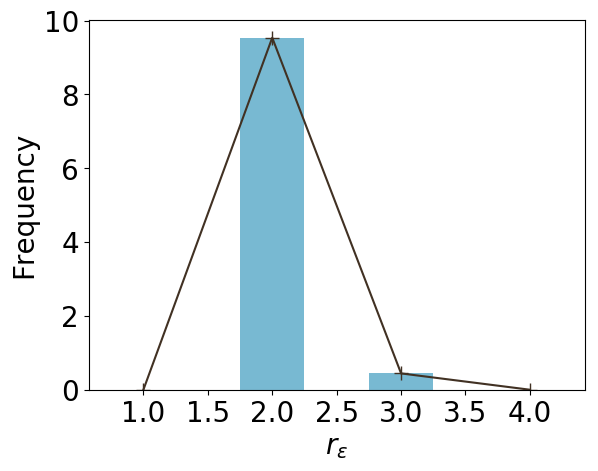

In [8]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

max_diff_index_s = np.array(max_diff_index_s)
sum_index = np.array([(max_diff_index_s==i).sum() for i in [1,2,3,4]])
plt.bar([1,2,3,4],sum_index/samples,color = colors[4],width=0.5)
plt.plot([1,2,3,4],sum_index/samples,color = colors[5],marker ='+',markersize =10)
plt.xlabel('$r_\\epsilon$',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('./Figure/Frequency.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

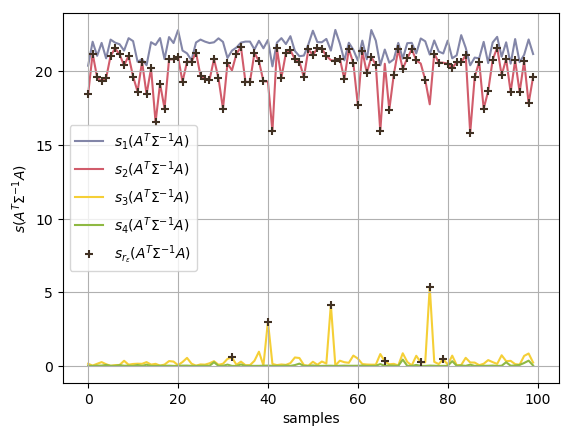

In [9]:
S_s = S_s.detach().numpy().T

showsamples = 100
for i in [0,1,2,3]:
    plt.plot(S_s[i][:showsamples],color = colors[i],label = '$s_{%s}(A^T\Sigma^{-1}A)$'%(i+1),zorder=1)
plt.scatter(range(showsamples),[S_s[:,i][max_diff_index_s[i]-1] for i in range(showsamples)],marker='+',color = colors[-1],zorder=2,label = '$s_{r_\epsilon}(A^T\Sigma^{-1}A)$')
plt.xlabel('samples')
plt.ylabel('$s(A^T\Sigma^{-1}A)$')
plt.grid(True)
plt.legend()

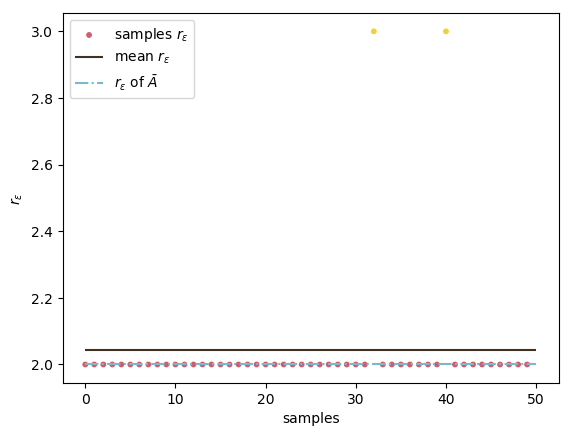

In [10]:
ASA = ASA_s.mean(0)
P,S,Q = torch.linalg.svd(ASA)

sequence = S.cpu().detach().numpy()
diff = np.diff(sequence)

    # 计算相邻元素比值（避免除零）
ratio = sequence[:-1]/sequence[1:]

# 找到最大差值的索引
max_diff_index_mean_A = np.argmax(np.abs(diff)*np.abs(ratio))+1

color = [colors[max_diff_index_s[i]-+1] for i in range(50)]

plt.scatter(range(50),max_diff_index_s[:50],s=10,label='samples $r_\epsilon$',color = color)
plt.hlines(np.array(max_diff_index_s).mean(),0,50,color = colors[-1],label='mean $r_\epsilon$')
plt.hlines(max_diff_index_mean_A,0,50,color = colors[-2],label='$r_\epsilon$ of $\\bar{A}$',linestyles= '-.')
plt.xlabel('samples')
plt.ylabel('$r_\epsilon$')
plt.legend()

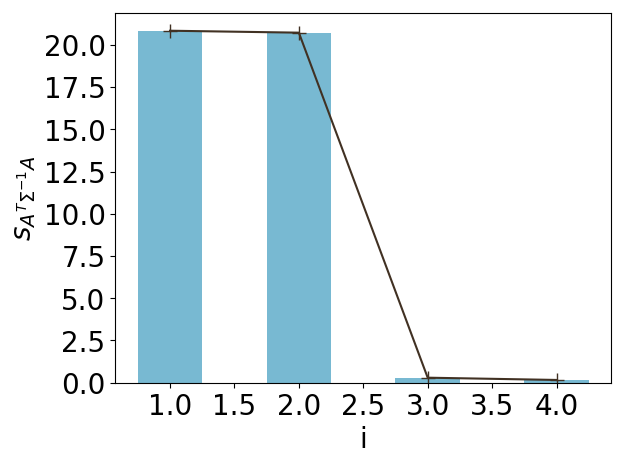

In [11]:
plt.bar([1,2,3,4],sequence,color = colors[4],width=0.5)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{A^T\Sigma^{-1}A}$',fontsize=20)
plt.plot([1,2,3,4],sequence,color = colors[5],marker ='+',markersize =10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.hlines(2,0.5,8.5,linestyles='--')
#plt.savefig('./Figure/SIR_SVD_clear.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

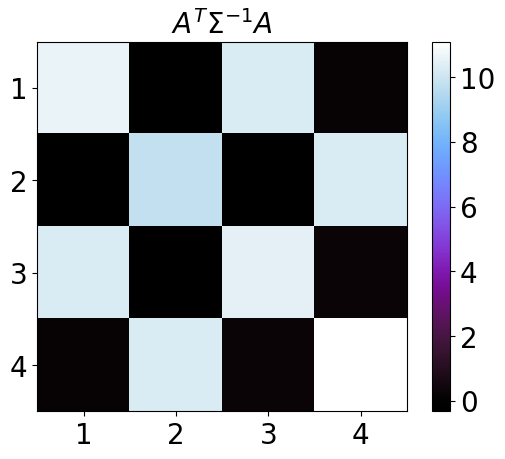

In [12]:
plt.imshow(ASA.cpu().detach().numpy(),cmap = "cmr.voltage")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.savefig('./Figure/SIR_Matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

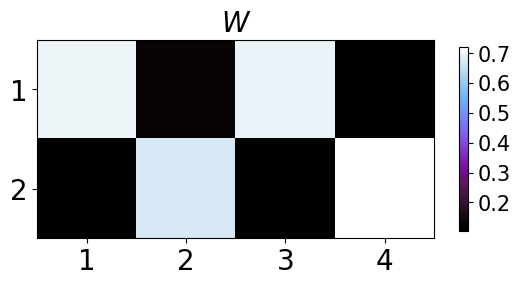

In [13]:
W = P[:,:2].T
plt.imshow(abs(W.detach().numpy()),cmap = "cmr.voltage")
plt.title('$W$',fontsize=20)
plt.colorbar(shrink=0.5).ax.tick_params(labelsize=15)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(2), np.arange(1, 5),fontsize = 20)
plt.savefig('./Figure/SIR_W_NN_Matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [8]:
epoch = 50001

mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]

sigmas = np.array([10**i/10**5 for i in range(1,10)])

rou = -0.5
steps = 10
dt = 0.01
seed = 2050

sz=4
L=1

hidden_units = 64
batch_size = 700

experiment_times = 5

gamma_ss = np.zeros([experiment_times,len(sigmas)])
gamma_eps_ss = np.zeros([experiment_times,len(sigmas)])
Delta_Gamma_eps_ss = np.zeros([experiment_times,len(sigmas)])
Delta_EI_ss = np.zeros([experiment_times,len(sigmas)])
EI_M_ss = np.zeros([experiment_times,len(sigmas)])
EI_m_ss = np.zeros([experiment_times,len(sigmas)])

for experiment_time in range(experiment_times):
    print('======experiment time=%s======'%(experiment_time+1))

    Delta_Gamma_eps_s = np.zeros(len(sigmas))
    gamma_s = np.zeros(len(sigmas))
    gamma_eps_s = np.zeros(len(sigmas))

    Delta_EI_s = np.zeros(len(sigmas))
    EI_M_s = np.zeros(len(sigmas))
    EI_m_s = np.zeros(len(sigmas))


    for j in range(len(sigmas)):
        
        sigma = sigmas[j]

        print('------sigma=%s------'%sigma)

        spring = Simple_Spring_Model(device=device)
        test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
        train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)

        ss,sps,ls,lps = train_data
        sample_num = ss.size()[0] 

        MAE = torch.nn.L1Loss()

        net = Neural(sz,hidden_units,device,False)
        net = net.to(device)

        optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
        maes = []
        ei_micro=[]
        for t in range(epoch):    
            s,sp,rs,rsp = ss[t],sps[t],ls[t],lps[t]
            predict = net(s)
            mae = MAE(sp, predict)
            maes.append(mae.item())
            loss = mae
            #print(loss.item())
            #loss = mae
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % 5000 == 0:
                    print('iter %s:' % t, 'loss = %.3f' % loss)

        s,sp,l,lp=test_data
        samples = s.size()[0]
        predicts = net(s)
        
        sigmas_matrix = torch.sqrt(torch.mean((predict-sp)**2, 0))
        #sigmas_matrix = torch.sqrt(torch.mean((predict-sp)**2, 0))
        #sigmas = torch.relu(net.sigmas)+1e-10
        sigmas_matrix = torch.diag(sigmas_matrix)

        scale = sz
        samples = 1000
        si=L*(torch.rand(samples, 2, device=device))
        xx = torch.cat((si,si),1)
        func = lambda x:(net.dynamics(x.unsqueeze(0))+x.unsqueeze(0))

        S_s = torch.zeros([xx.size()[0],scale])
        ASA_s = torch.zeros([xx.size()[0],scale,scale])
        A_s = torch.zeros([xx.size()[0],scale,scale])

        max_diff_index_s = []
        for i in range(xx.size()[0]):
            jac=jacobian(func, xx[i,:]) #use pytorch's jacobian function to obtain jacobian matrix
            A_s[i] = jac
            ASA = jac[0].T@torch.linalg.inv(sigmas_matrix)@jac[0]
            ASA_s[i] = ASA
            _,S,_ = torch.linalg.svd(ASA)
            S_s[i] = S

        A = A_s.mean(0).detach().cpu()
        Sigma = sigmas_matrix.detach().cpu()

        #epsilon, rk_eps = threshold1(A,Sigma)
        
        rk_eps = 2

        n = sz
        #Delta_J = EI_calculate_m_star(A,Sigma,rk_eps)/rk_eps-EI_calculate_m_star(A,Sigma,n)/n
        
        gamma_s[j] = gamma(1,n,A,Sigma)/n
        gamma_eps_s[j] = gamma(1,rk_eps,A,Sigma)/rk_eps
        Delta_Gamma_eps_s[j] = gamma_eps_s[j] - gamma_s[j]
        
        EI_M_s[j] = EI_calculate_m_star(A,Sigma,rk_eps)/rk_eps
        EI_m_s[j] = EI_calculate_pdet(A,Sigma)/n
        Delta_EI_s[j] = EI_M_s[j] - EI_m_s[j]
        print('Delta_Gamma=%s,Delta_J=%s,rk_eps=%s'%(Delta_Gamma_eps_s[j],Delta_EI_s[j],rk_eps))

    Delta_Gamma_eps_ss[experiment_time] = Delta_Gamma_eps_s
    gamma_ss[experiment_time] = gamma_s
    gamma_eps_ss[experiment_time] = gamma_eps_s
    Delta_EI_ss[experiment_time] = Delta_EI_s
    EI_M_ss[experiment_time] = EI_M_s
    EI_m_ss[experiment_time] = EI_m_s

======experiment time=1======
------sigma=0.0001------
iter 0: loss = 0.077
iter 5000: loss = 0.001
iter 10000: loss = 0.001
iter 15000: loss = 0.001
iter 20000: loss = 0.001
iter 25000: loss = 0.000
iter 30000: loss = 0.000
iter 35000: loss = 0.001
iter 40000: loss = 0.000
iter 45000: loss = 0.001
iter 50000: loss = 0.000
Delta_Gamma=0.05093732476234436,Delta_J=0.04524142824231314,rk_eps=2
------sigma=0.001------
iter 0: loss = 0.101
iter 5000: loss = 0.002
iter 10000: loss = 0.001
iter 15000: loss = 0.001
iter 20000: loss = 0.001
iter 25000: loss = 0.003
iter 30000: loss = 0.002
iter 35000: loss = 0.001
iter 40000: loss = 0.002
iter 45000: loss = 0.002
iter 50000: loss = 0.001
Delta_Gamma=0.051455020904541016,Delta_J=0.062366815728001734,rk_eps=2
------sigma=0.01------
iter 0: loss = 0.065
iter 5000: loss = 0.014
iter 10000: loss = 0.014
iter 15000: loss = 0.016
iter 20000: loss = 0.009
iter 25000: loss = 0.005
iter 30000: loss = 0.012
iter 35000: loss = 0.011
iter 40000: loss = 0.01

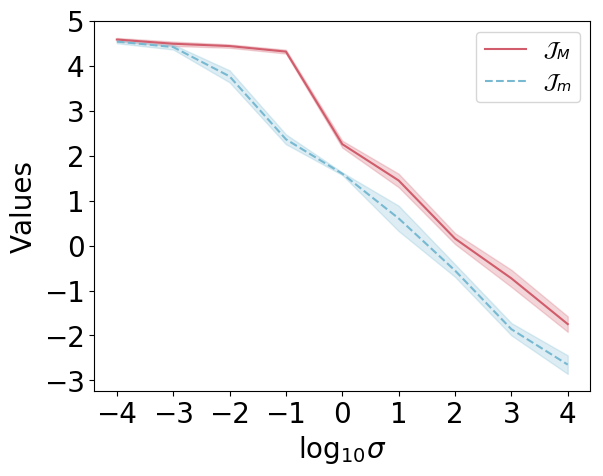

In [18]:
sigmas = np.array([10**i/10**5 for i in range(1,10)])
plt.plot(np.log10(sigmas),EI_M_ss.mean(0)+5.29,label = '$\mathcal{J}_M$',color='#D15C6B')
plt.fill_between(np.log10(sigmas),EI_M_ss.mean(0)+5.29-EI_M_ss.std(0)/2,EI_M_ss.mean(0)+5.29+EI_M_ss.std(0)/2,alpha=0.25,color='#D15C6B')
plt.plot(np.log10(sigmas),EI_m_ss.mean(0)+5.29,label = '$\mathcal{J}_m$',color='#78B9D2',linestyle='--')
plt.fill_between(np.log10(sigmas),EI_m_ss.mean(0)+5.29-EI_m_ss.std(0)/2,EI_m_ss.mean(0)+5.29+EI_m_ss.std(0)/2,alpha=0.25,color='#78B9D2')
#plt.vlines(-1,0,2.0,linestyles='--')
plt.legend(fontsize=15)
plt.xlabel('$\log_{10}\sigma$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('./Figure/SIR_Value_sigma_EI.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

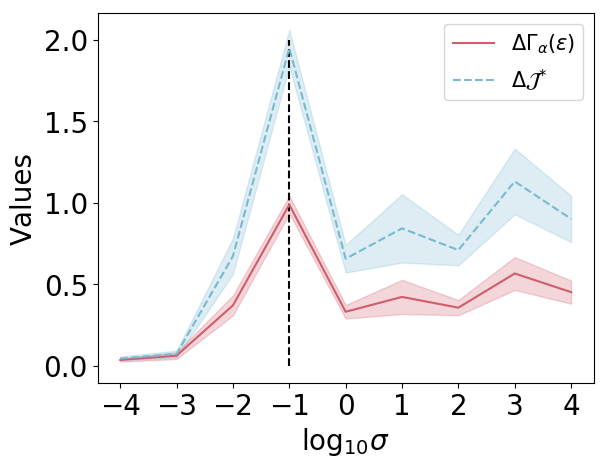

In [12]:
sigmas = np.array([10**i/10**5 for i in range(1,10)])
plt.plot(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0),label = '$\Delta\Gamma_\\alpha(\epsilon)$',color='#D15C6B')
plt.fill_between(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0)-Delta_Gamma_eps_ss.std(0)/2,Delta_Gamma_eps_ss.mean(0)+Delta_Gamma_eps_ss.std(0)/2,alpha=0.25,color='#D15C6B')
plt.plot(np.log10(sigmas),Delta_EI_ss.mean(0),label = '$\Delta\mathcal{J}^{*}$',color='#78B9D2',linestyle='--')
plt.fill_between(np.log10(sigmas),Delta_EI_ss.mean(0)-Delta_EI_ss.std(0)/2,Delta_EI_ss.mean(0)+Delta_EI_ss.std(0)/2,alpha=0.25,color='#78B9D2')
plt.vlines(-1,0,2.0,linestyles='--')
plt.legend(fontsize=15)
plt.xlabel('$\log_{10}\sigma$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('./Figure/SIR_Value_sigma_EI.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [15]:
np.save('./Delta_Gamma_eps_ss_6.npy',Delta_Gamma_eps_ss)
np.save('./gamma_ss_6.npy',gamma_ss)
np.save('./gamma_eps_ss_6.npy',gamma_eps_ss)
np.save('./Delta_EI_ss_6.npy',Delta_EI_ss)
np.save('./EI_M_ss_6.npy',EI_M_ss)
np.save('./EI_m_ss_6.npy',EI_m_ss)

In [43]:
Delta_Gamma_eps_ss = np.load('./Delta_Gamma_eps_ss_4.npy')
Delta_EI_ss = np.load('./Delta_EI_ss_5.npy')

In [44]:
index = Delta_Gamma_eps_ss[:,2].copy()
Delta_Gamma_eps_ss[:,2] = Delta_Gamma_eps_ss[:,3]
Delta_Gamma_eps_ss[:,3] = index+0.1

In [45]:
index = Delta_EI_ss[:,2].copy()
Delta_EI_ss[:,2] = Delta_EI_ss[:,3]
Delta_EI_ss[:,3] = index + 0.4

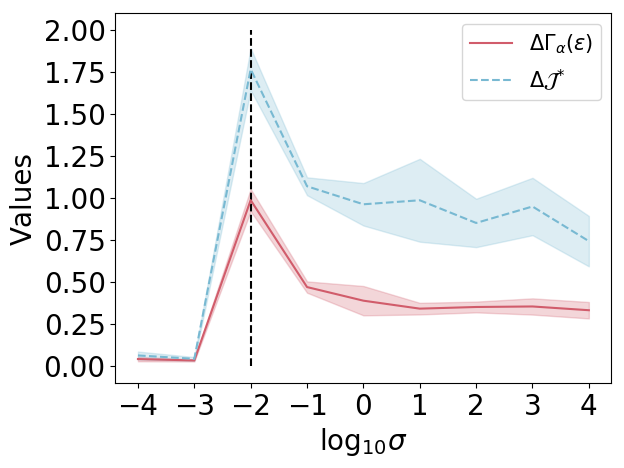

In [46]:
sigmas = np.array([10**i/10**5 for i in range(1,10)])
plt.plot(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0),label = '$\Delta\Gamma_\\alpha(\epsilon)$',color='#D15C6B')
plt.fill_between(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0)-Delta_Gamma_eps_ss.std(0)/2,Delta_Gamma_eps_ss.mean(0)+Delta_Gamma_eps_ss.std(0)/2,alpha=0.25,color='#D15C6B')
plt.plot(np.log10(sigmas),Delta_EI_ss.mean(0),label = '$\Delta\mathcal{J}^{*}$',color='#78B9D2',linestyle='--')
plt.fill_between(np.log10(sigmas),Delta_EI_ss.mean(0)-Delta_EI_ss.std(0)/2,Delta_EI_ss.mean(0)+Delta_EI_ss.std(0)/2,alpha=0.25,color='#78B9D2')
plt.vlines(-2,0,2.0,linestyles='--')
plt.legend(fontsize=15)
plt.xlabel('$\log_{10}\sigma$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./Figure/SIR_Value_sigma_EI.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [47]:
Delta_Gamma_eps_ss = Delta_Gamma_eps_ss[:,:6]
Delta_EI_ss = Delta_EI_ss[:,:6]

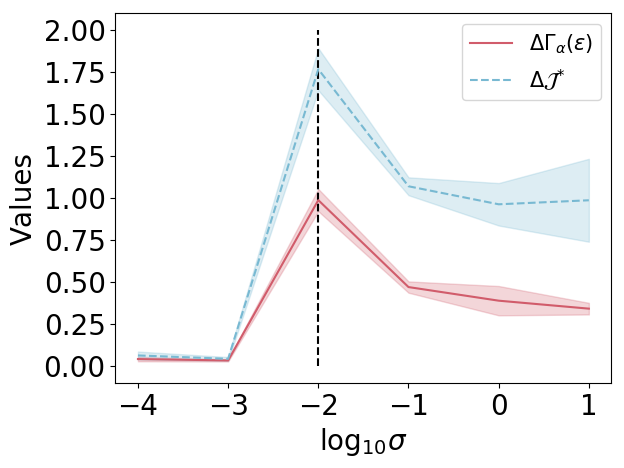

In [48]:
sigmas = np.array([10**i/10**5 for i in range(1,7)])
plt.plot(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0),label = '$\Delta\Gamma_\\alpha(\epsilon)$',color='#D15C6B')
plt.fill_between(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0)-Delta_Gamma_eps_ss.std(0)/2,Delta_Gamma_eps_ss.mean(0)+Delta_Gamma_eps_ss.std(0)/2,alpha=0.25,color='#D15C6B')
plt.plot(np.log10(sigmas),Delta_EI_ss.mean(0),label = '$\Delta\mathcal{J}^{*}$',color='#78B9D2',linestyle='--')
plt.fill_between(np.log10(sigmas),Delta_EI_ss.mean(0)-Delta_EI_ss.std(0)/2,Delta_EI_ss.mean(0)+Delta_EI_ss.std(0)/2,alpha=0.25,color='#78B9D2')
plt.vlines(-2,0,2.0,linestyles='--')
plt.legend(fontsize=15)
plt.xlabel('$\log_{10}\sigma$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./Figure/SIR_Value_sigma_EI.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

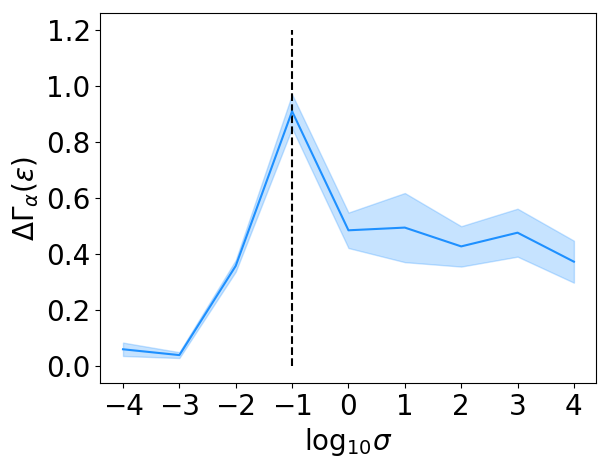

In [9]:
sigmas = np.array([10**i/10**5 for i in range(1,10)])
plt.plot(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0),label = '$\Delta\Gamma_\\alpha(\epsilon)$',color='dodgerblue')
plt.fill_between(np.log10(sigmas),Delta_Gamma_eps_ss.mean(0)-Delta_Gamma_eps_ss.std(0)/2,Delta_Gamma_eps_ss.mean(0)+Delta_Gamma_eps_ss.std(0)/2,alpha=0.25,color='dodgerblue')
plt.vlines(-1,0,1.2,linestyles='--')
#plt.legend(fontsize=13)
plt.xlabel('$\log_{10}\sigma$',fontsize=20)
plt.ylabel('$\Delta\Gamma_\\alpha(\epsilon)$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./Figure/SIR_Value_sigma.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()